In [1]:
import os
import time

from selenium.webdriver.remote.webelement import WebElement

from core.core_utils import *
from core.core_chrome import CoreChrome


In [3]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-

'''
安装第三方模块
pip install pandas
pip install openpyxl
pip install selenium

'''

import os
import time

from selenium.webdriver.remote.webelement import WebElement
import core.core_utils as utils
from core.core_chrome import CoreChrome


class Main(CoreChrome):

    def __init__(self):
        BASEDIR = os.getcwd() #当前工作路径
        CHROME_PATH = os.path.join(BASEDIR, 'chrome\\chrome.exe')
        CHROME_DRIVER_PATH = os.path.join(BASEDIR, 'chrome\\chromedriver.exe')
        USER_PATH = os.path.join(BASEDIR, 'chrome\\userdata')
        super(Main, self).__init__(CHROME_DRIVER_PATH, CHROME_PATH, USER_PATH)
        
    def run(self):
        utils.create_dir('file')
        utils.clear_dir('file')
        # 先打开网页噻
        self.get('https://www.cnki.net/')

        # 点击高级检索
        high_search_ele: WebElement = self.visible_css_element('#highSearch') 
        if high_search_ele:
            high_search_url = high_search_ele.get_attribute('href')
            self.get(high_search_url)
        
        #题名:(糖尿病视网膜病变)
        self.retrieval_first_line_input('篇名', '糖尿病视网膜病变')

        gradetxt_dd_eles: WebElement = self.visible_css_elements('#gradetxt dd') # 定位搜索主div dd
        # and 主题:(发病机制 or 病机) 
        self.retrieval_line_input(gradetxt_dd_eles[1], 'AND', '主题', '发病机制 + 病机')
        # self.retrieval_line_input(gradetxt_dd_eles[2], 'OR', '主题', '病机')

        #and 题名:(现状 or 进展 or 综述 or 概况 or 概述))
        ele = self.add_retrieval_line()
        self.retrieval_line_input(ele, 'AND', '篇名', '现状 + 进展 + 概述 + 概况 + 综述')

        #and 题名:(现状 or 进展 or 综述 or 概况 or 概述))
        # ele = self.add_retrieval_line()
        # self.retrieval_line_input(ele, 'AND', '篇名', '现状')
        # ele = self.add_retrieval_line()
        # self.retrieval_line_input(ele, 'OR', '篇名', '进展')
        # ele = self.add_retrieval_line()
        # self.retrieval_line_input(ele, 'OR', '篇名', '综述')
        # ele = self.add_retrieval_line()
        # self.retrieval_line_input(ele, 'OR', '篇名', '概况')
        # ele = self.add_retrieval_line()
        # self.retrieval_line_input(ele, 'OR', '篇名', '概述')

        #and 出版时间:[2018-01-01 TO *}
        datebox0_ele: WebElement = self.visible_css_element('#datebox0') # 发表时间
        self.execute_script('arguments[0].removeAttribute("readonly")',datebox0_ele)
        datebox0_ele.send_keys('2018-01-01')

        self.visible_css_element('.btn-search').click() #检索
        self.execute_script('window.scrollTo(0,document.body.scrollHeight)')

        self.execute_script("document.documentElement.scrollTop=10000")

        # 指定页数翻页保存表格
        # 处理函数
        # css
        # 页数
        page_count = self.compute_page_count()
        if page_count > 1 :
            self.page_down(self.write_table,'.pages', '.result-table-list td', '.pages div.pagesnums a', page_count)
        else:
            self.write_table()

    def compute_page_count(self):
        '''计算总页数以实现翻页'''
        are_page_count_el = self.visible_css_element('#perPageDiv span')
        text = are_page_count_el.text
        are_page_count = utils.extracting_numbers(text)

        result_count_el = self.visible_css_element('.pagerTitleCell em')
        text = result_count_el.text
        result_count = utils.extracting_numbers(text)

        page_count = utils.round_up(result_count/are_page_count)
        return page_count

    def write_table(self,page_index):
        '''获取到表格后的操作函数，可在这修改成其它形式'''
        table_ele: WebElement = self.visible_css_element('.result-table-list') # 发表时间
        df = self.settr_column_datas(table_ele)
        file = f'file\\{page_index}_{utils.timestamp()}.csv'
        df.to_csv(file)

    def add_retrieval_line(self):
        '''添加一行新的检索条件，并返回元素Element'''
        add_line_ele: WebElement = self.visible_css_element('#gradetxt dt a') # 点击第一行左边下拉框
        add_line_ele.click()
        gradetxt_dd_eles: WebElement = self.visible_css_elements('#gradetxt dd') # 定位搜索主div dd
        print(len(gradetxt_dd_eles))
        return gradetxt_dd_eles[-1]

    def retrieval_first_line_input(self, category, text):
        '''填写首行检索条件'''
        # slector: #gradetxt > dd:nth-child(2) > div.input-box > div.sort.reopt > div.sort-default > span
        # element: <span value="TI" data-opter="TOPRANK" data-value="SU" data-opt="BOTH">篇名</span>
        # document.querySelector("#gradetxt > dd:nth-child(2) > div.input-box > div.sort.reopt > div.sort-default > span")
        # 
        sort_ele: WebElement = self.visible_css_element('#gradetxt .nological+div .sort.reopt span') # 点击第一行左边下拉框
        sort_ele.click()
        self.visible_linktext_element(category).click() # 选择下拉框选项
        self.move_to_offset(50,50) # 移动一下鼠标
        gradetxt_1 = self.visible_css_element('#gradetxt .nological+div div~input') 
        self.css_el_input(gradetxt_1, text)
        if category == '篇名':
            # #gradetxt > dd:nth-child(2) > div.input-box > div.sort.special   
            sort_accurate: WebElement = self.visible_css_element('#gradetxt .nological+div .special span') # 点击第一行左边下拉框
            sort_accurate.click()
            self.visible_linktext_element("模糊").click() # 选择下拉框选项
        else:
            print('Category does not equal to 篇名')

        
        
    def retrieval_line_input(self, main_ele, logic, category, text):
        '''填写一行检索条件'''
        logical_ele: WebElement = self.css_to_element(main_ele,'.logical')  # 点击第三行左边第一个下拉框
        logical_ele.click()
        self.visible_linktext_element(logic).click() # 选择下拉框选项
        logical_ele: WebElement = self.css_to_element(main_ele,'.reopt') # 点击第三行左边第二个下拉框
        logical_ele.click()
        self.visible_linktext_element(category).click() # 选择下拉框选项
        gradetxt = self.css_to_element(main_ele,'.input-box div~input') # 输入， 添加检索栏gradetxt-（2）递增
        self.css_el_input(gradetxt, text)
        if category == '篇名':
            # #gradetxt > dd:nth-child(2) > div.input-box > div.sort.special   
            sort_accurate: WebElement = self.css_to_element(main_ele,'.special span') # 点击第一行左边下拉框
            sort_accurate.click()
            self.visible_linktext_element("模糊").click() # 选择下拉框选项
        else:
            print('Category does not equal to 篇名')


if __name__ == '__main__':

    main = Main()
    main.run()
    main.quit()
    # 合并所有表格
    # total = utils.merge_excel_to_dir('file')
    # total.to_excel('res.xlsx')

Category does not equal to 篇名
4
点击第1页完成！
点击第2页完成！
点击第3页完成！


看起来你可能在寻找某种形式的HTML或CSS选择器的解释。这段文字"#gradetxt .nological+div .sort.reopt span"看起来像是CSS选择器。这是HTML元素的一种标记方式，用于定位HTML文件中的某些特定元素，常用于网页设计和网页数据抓取。每一个符号和名称都对应HTML元素的一种属性。
具体来说：

    #gradetxt: 这是一个id选择器，用于找到id属性为"gradetxt"的元素。
    .nological: 这是一个类选择器，用于找到类属性为"nological"的元素。
    +div: 这是一个相邻兄弟选择器，用于找到".nological"元素后面紧邻的"div"元素。
    .sort: 这是一个类选择器，用于找到类属性为"sort"的元素。
    .reopt: 这是一个类选择器，用于找到类属性为"reopt"的元素。
    span: 这是一个元素选择器，用于找到所有的"span"元素。

总的来说，这个选择器从左到右的逻辑是：找到id为"gradetxt"的元素，然后在其中找到类为"nological"的元素，然后找到它后面紧邻的div元素，然后在其中找到类为"sort"和"reopt"的元素，最后定位到这些元素下的所有span元素。
如果我的解释并不能满足你的需求，或者你想要了解其它的信息，请告诉我。

In [4]:
import os
import glob
import pandas as pd

# file/ 是你的文件夹目录，确保在最后加上 /
input_path = "file/"
output_path = "output/"

# 找到文件夹中所有的 .csv 文件
all_files = glob.glob(os.path.join(input_path, "*.csv"))
print(f"Found {len(all_files)} files.")

Found 3 files.


In [5]:
# 读取并合并所有文件
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)

# 检查前几行合并后的数据
print(df_merged.head())

# 输出合并后的文件到 output 文件夹
os.makedirs(output_path, exist_ok=True)
df_merged.to_csv(output_path + "merged.csv", index=False)

# # 删除源文件
# for file in all_files:
#     os.remove(file)



   Unnamed: 0                                                 题名  \
0           1  ('补体蛋白调控靶点在糖尿病视网膜病变中的作用及临床研究进展  网络首发  免费', 'ht...   
1           2  ('糖尿病性视网膜病变的发病机制：miRNAs研究进展  免费', 'https://kns...   
2           3  ('姜黄素治疗糖尿病视网膜病变作用机制的研究进展  免费', 'https://kns.cn...   
3           4  ('线粒体DNA在糖尿病视网膜病变发病机制中的作用研究进展  免费', 'https://k...   
4           5  ('糖尿病视网膜病变的发病机制及中医治疗进展  网络首发  免费', 'https://kn...   

                           作者        来源              发表时间 数据库  被引   下载  \
0              王绪瑞;孙洪岩;刘丹;杨明明    国际眼科杂志  2024-03-10 08:07  期刊 NaN   74   
1                      刘彤;吴松笛     眼科新进展        2024-03-05  期刊 NaN   38   
2                     樊靖蝶;徐新荣    中国医药科学        2024-01-15  期刊 NaN   82   
3  侯小玉;接传红;王建伟;刘自强;邓宇;李媛媛;蔡文静     眼科新进展        2023-12-05  期刊 NaN  320   
4                      孙祎遥;赵洋  实用中医内科杂志  2023-11-09 19:32  期刊 NaN  971   

           操作  
0    下载  在线阅读  
1  下载  HTML阅读  
2  下载  HTML阅读  
3  下载  HTML阅读  
4  下载  HTML阅读  


In [6]:
df_merged.head()

,Unnamed: 0,题名,作者,来源,发表时间,数据库,被引,下载,操作
0,1,"('补体蛋白调控靶点在糖尿病视网膜病变中的作用及临床研究进展 网络首发 免费', 'ht...",王绪瑞;孙洪岩;刘丹;杨明明,国际眼科杂志,2024-03-10 08:07,期刊,NaN,74,下载 在线阅读
1,2,"('糖尿病性视网膜病变的发病机制：miRNAs研究进展 免费', 'https://kns...",刘彤;吴松笛,眼科新进展,2024-03-05,期刊,NaN,38,下载 HTML阅读
2,3,"('姜黄素治疗糖尿病视网膜病变作用机制的研究进展 免费', 'https://kns.cn...",樊靖蝶;徐新荣,中国医药科学,2024-01-15,期刊,NaN,82,下载 HTML阅读
3,4,"('线粒体DNA在糖尿病视网膜病变发病机制中的作用研究进展 免费', 'https://k...",侯小玉;接传红;王建伟;刘自强;邓宇;李媛媛;蔡文静,眼科新进展,2023-12-05,期刊,NaN,320,下载 HTML阅读
4,5,"('糖尿病视网膜病变的发病机制及中医治疗进展 网络首发 免费', 'https://kn...",孙祎遥;赵洋,实用中医内科杂志,2023-11-09 19:32,期刊,NaN,971,下载 HTML阅读


In [7]:
# 将NaN值替换为0
df_merged.fillna(0, inplace=True)
df_merged.head()

,Unnamed: 0,题名,作者,来源,发表时间,数据库,被引,下载,操作
0,1,"('补体蛋白调控靶点在糖尿病视网膜病变中的作用及临床研究进展 网络首发 免费', 'ht...",王绪瑞;孙洪岩;刘丹;杨明明,国际眼科杂志,2024-03-10 08:07,期刊,0.0,74,下载 在线阅读
1,2,"('糖尿病性视网膜病变的发病机制：miRNAs研究进展 免费', 'https://kns...",刘彤;吴松笛,眼科新进展,2024-03-05,期刊,0.0,38,下载 HTML阅读
2,3,"('姜黄素治疗糖尿病视网膜病变作用机制的研究进展 免费', 'https://kns.cn...",樊靖蝶;徐新荣,中国医药科学,2024-01-15,期刊,0.0,82,下载 HTML阅读
3,4,"('线粒体DNA在糖尿病视网膜病变发病机制中的作用研究进展 免费', 'https://k...",侯小玉;接传红;王建伟;刘自强;邓宇;李媛媛;蔡文静,眼科新进展,2023-12-05,期刊,0.0,320,下载 HTML阅读
4,5,"('糖尿病视网膜病变的发病机制及中医治疗进展 网络首发 免费', 'https://kn...",孙祎遥;赵洋,实用中医内科杂志,2023-11-09 19:32,期刊,0.0,971,下载 HTML阅读


In [8]:
# 找到 'column1' 列最大值对应的行
max_row = df_merged.loc[df_merged['被引'].idxmax()]
max_row

Unnamed: 0                                                   37
题名            ('糖尿病视网膜病变发病机制及潜在治疗研究进展  免费', 'https://kns.cnk...
作者                                                  张凤俊;李晶明;刘秋平
来源                                                        眼科新进展
发表时间                                                 2020-07-05
数据库                                                          期刊
被引                                                         82.0
下载                                                         2969
操作                                                   下载  HTML阅读
Name: 36, dtype: object

In [9]:
# 将日期时间列转为字符串，以空格(' ')作为分隔符，取出日期部分
df_merged['发表时间'] = df_merged['发表时间'].str.split(' ', expand=True)[0]

# 转换日期时间列到 datetime，忽略错误
df_merged['发表时间'] = pd.to_datetime(df_merged['发表时间'], errors='coerce')

# 提取年份信息
df_merged['year'] = df_merged['发表时间'].dt.year


df_merged.head()

,Unnamed: 0,题名,作者,来源,发表时间,数据库,被引,下载,操作,year
0,1,"('补体蛋白调控靶点在糖尿病视网膜病变中的作用及临床研究进展 网络首发 免费', 'ht...",王绪瑞;孙洪岩;刘丹;杨明明,国际眼科杂志,2024-03-10,期刊,0.0,74,下载 在线阅读,2024
1,2,"('糖尿病性视网膜病变的发病机制：miRNAs研究进展 免费', 'https://kns...",刘彤;吴松笛,眼科新进展,2024-03-05,期刊,0.0,38,下载 HTML阅读,2024
2,3,"('姜黄素治疗糖尿病视网膜病变作用机制的研究进展 免费', 'https://kns.cn...",樊靖蝶;徐新荣,中国医药科学,2024-01-15,期刊,0.0,82,下载 HTML阅读,2024
3,4,"('线粒体DNA在糖尿病视网膜病变发病机制中的作用研究进展 免费', 'https://k...",侯小玉;接传红;王建伟;刘自强;邓宇;李媛媛;蔡文静,眼科新进展,2023-12-05,期刊,0.0,320,下载 HTML阅读,2023
4,5,"('糖尿病视网膜病变的发病机制及中医治疗进展 网络首发 免费', 'https://kn...",孙祎遥;赵洋,实用中医内科杂志,2023-11-09,期刊,0.0,971,下载 HTML阅读,2023


In [10]:
# 分类并计数文章
df_grouped = df_merged.groupby('year')['题名'].count()

df_grouped

year
2018     8
2019     7
2020    11
2021     7
2022     9
2023    12
2024     3
Name: 题名, dtype: int64

In [11]:
df_grouped.index, df_grouped.values

(Index([2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype='int32', name='year'),
 array([ 8,  7, 11,  7,  9, 12,  3], dtype=int64))

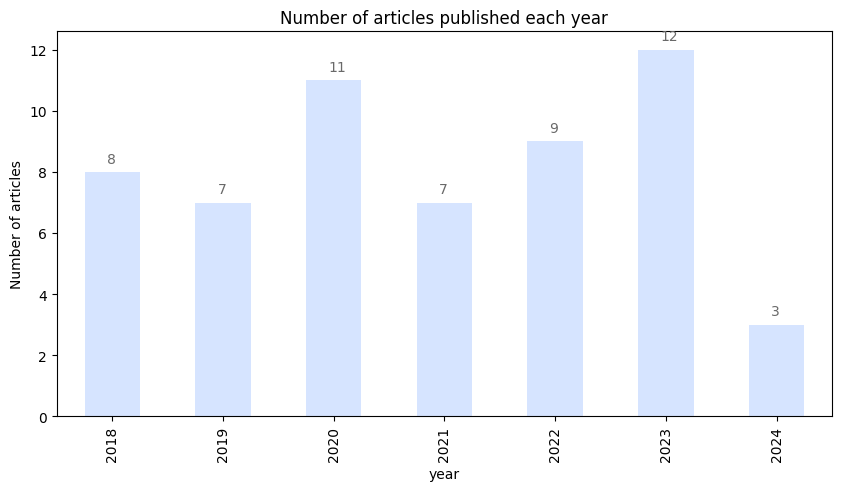

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=[10,5])

# Your option of macaron color palette
macaron_palette = ['#99a3a4', '#f5f6f7', '#d6e4ff', '#f9cb9c', '#eb6e44', '#674172']

# Plotting the bar chart with custom color palette
ax = df_grouped.plot(kind='bar', color=macaron_palette[2], edgecolor='none')

# Add labels on the top of the bars
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()+0.3, str(i.get_height()), color='dimgrey')
    
plt.ylabel('Number of articles')
plt.title('Number of articles published each year')
plt.show()